# Part 1: Kaggle Competition

This piece of code classifies BBC news article downloaded from Kaggle using unsupervised (matrix factorization) methods, and compare its performance to supervised learning methods

In [311]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import PorterStemmer, WordNetLemmatizer

from itertools import permutations

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

def stemmed_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

def lemmatized_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Sourcing

In [250]:
# !git clone  https://github.com/chuinbu/CSCA5632_BBCNews.git

In [251]:
# !ls '/content/CSCA5632_BBCNews/learn-ai-bbc'

In [252]:
bbc_test = pd.read_csv("/content/CSCA5632_BBCNews/learn-ai-bbc/BBC News Test.csv")
bbc_test_solution = pd.read_csv("/content/CSCA5632_BBCNews/learn-ai-bbc/BBC News Sample Solution.csv")
bbc_train = pd.read_csv("/content/CSCA5632_BBCNews/learn-ai-bbc/BBC News Train.csv")

# EDA
In this section, I will be performing exploratory data analysis using NLP techniques

In [253]:
bbc_train['Tokens'] = bbc_train['Text'].apply(word_tokenize)
bbc_test['Tokens'] = bbc_test['Text'].apply(word_tokenize)

In [254]:
bbc_train.info() # shape of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
 3   Tokens     1490 non-null   object
dtypes: int64(1), object(3)
memory usage: 46.7+ KB


In [255]:
bbc_train.head() # data example

,ArticleId,Text,Category,Tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex-boss, launches, defence, lawyers..."
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, bosses, in, $, 168m, payout, eighteen,..."


In [256]:
print(bbc_train.Category.value_counts()) # we have 5 categories altogether

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


In [257]:
print(bbc_train.isnull().sum()) # missing values?
print(bbc_test.isnull().sum()) # missing values?

ArticleId    0
Text         0
Category     0
Tokens       0
dtype: int64
ArticleId    0
Text         0
Tokens       0
dtype: int64


In [258]:
# EDA: Distribution of token length
bbc_train['token_length'] = bbc_train['Tokens'].apply(len)

# EDA stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
bbc_train['stopwords_count'] = bbc_train['Tokens'].apply(lambda x: sum(1 for token in x if token.lower() in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0, 0.5, 'Frequency')

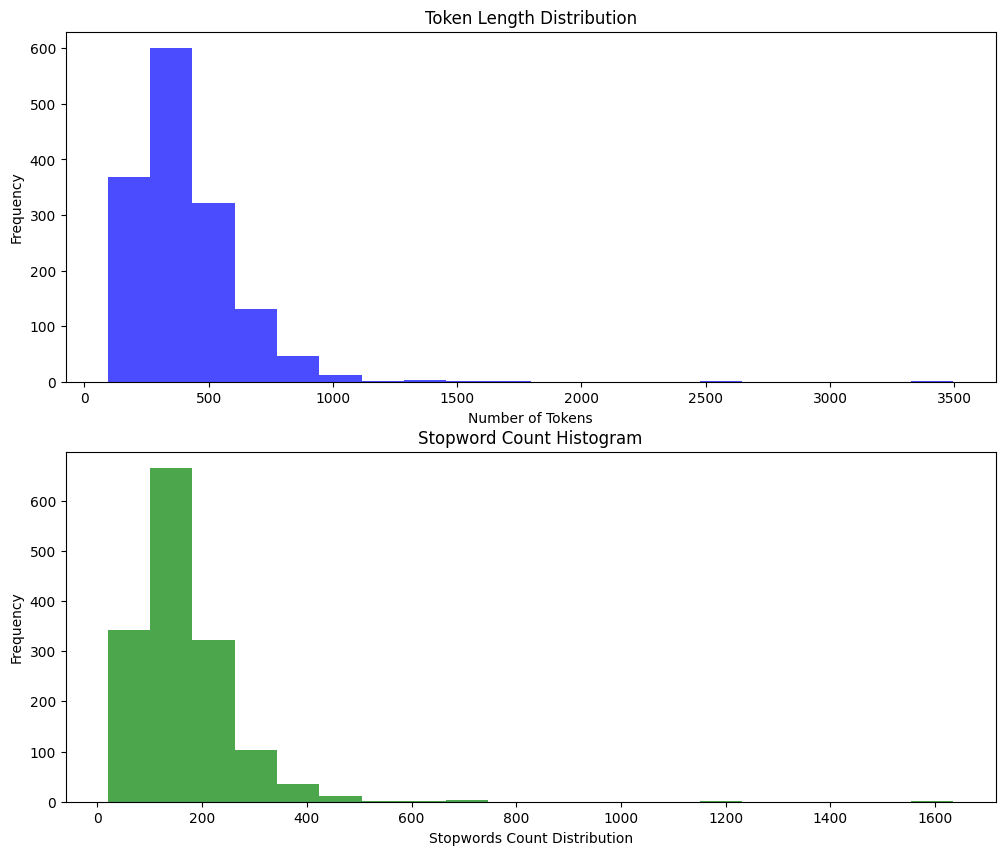

In [259]:
# EDA Plots

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].hist(bbc_train['token_length'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Token Length Distribution')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

axes[1].hist(bbc_train['stopwords_count'], bins=20, color='green', alpha=0.7)
axes[1].set_title('Stopword Count Histogram')
axes[1].set_xlabel('Stopwords Count Distribution')
axes[1].set_ylabel('Frequency')

Based on the EDA - my goal is to try to remove the stopwords from the analysis (this can be done using NLTK's Tfidfvectorizer - see reference). I would also explore stemming and lemming the words in text before transforming the text into matrix M for factorization

# Data Pre-processing

In [260]:
# remove stopwords
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000, max_df=0.95, min_df=2) # remove outlier from previous picture (see Number of Tokens)

# stemming
stemmer = PorterStemmer()
bbc_train['Text'] = bbc_train['Text'].apply(stemmed_words)
bbc_test['Text'] = bbc_test['Text'].apply(stemmed_words)

# lemming
lemmatizer = WordNetLemmatizer()
bbc_train['Text'] = bbc_train['Text'].apply(lemmatized_words)
bbc_test['Text'] = bbc_test['Text'].apply(lemmatized_words)

# obtain matrix M
matrixM = vectorizer.fit_transform(bbc_train['Text'])
matrixM_test = vectorizer.fit_transform(bbc_test['Text'])

# Factorizing Matrix M using NMF - In Sample Prediction

In [261]:
topics = 5
nmf = NMF(n_components=topics)
W = nmf.fit_transform(matrixM)
H = nmf.components_

nmf_test = NMF(n_components=topics)
W_test = nmf_test.fit_transform(matrixM_test)
H_test = nmf_test.components_

In [262]:
print(W)

[[0.03164756 0.         0.05170952 0.00321072 0.00766691]
 [0.         0.         0.2047843  0.         0.        ]
 [0.02794651 0.02181165 0.11202087 0.00261898 0.0225994 ]
 ...
 [0.         0.01134662 0.15459292 0.00650371 0.        ]
 [0.         0.         0.02622921 0.01305602 0.20465785]
 [0.         0.         0.         0.         0.12340123]]


In [263]:
print(H)

[[9.38450095e-02 0.00000000e+00 2.65036264e-02 ... 2.48958307e-03
  1.37483359e-02 0.00000000e+00]
 [1.73421025e-02 4.67422317e-02 6.16059541e-02 ... 0.00000000e+00
  0.00000000e+00 7.77337384e-02]
 [1.34766464e-01 7.98473377e-04 8.26957642e-02 ... 2.74791260e-02
  1.13856302e-01 5.29590737e-05]
 [4.30298762e-02 1.71523978e-03 4.06475862e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.36220539e-02 0.00000000e+00 5.12605561e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


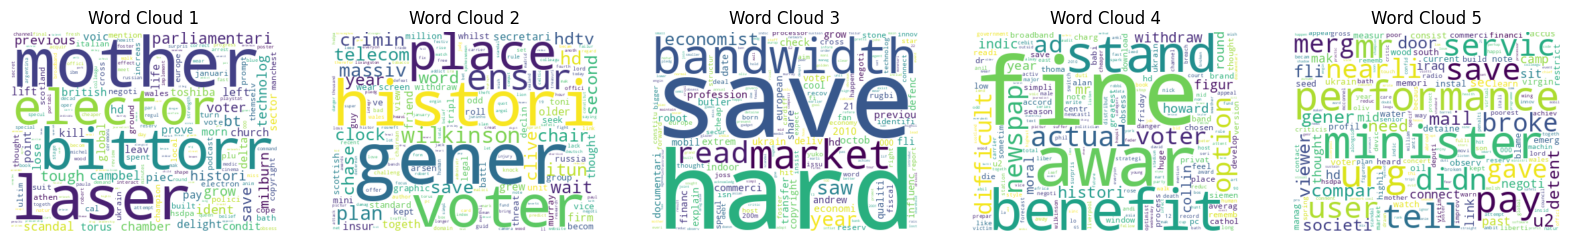

In [264]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

features = vectorizer.get_feature_names_out()

for cloudI, topic in enumerate(H):
    top_terms_dict = {features[i]: topic[i] for i in range(len(topic))}

    # Generate the word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(top_terms_dict)

    # Display the word cloud in the subplot
    axes[cloudI].imshow(wordcloud, interpolation='bilinear')
    axes[cloudI].set_title(f"Word Cloud {cloudI + 1}")
    axes[cloudI].axis("off")

In order to see which category fits with which word cloud, I will use a permutation of the categories and assign to the word clouds. The permutation that leads to the highest in-sample accuracy will be my final permutation. Using this method, I was able to an in-sample prediction accuracy of about 90%

In [265]:
categories = list(set(bbc_train['Category'].unique()))
category_permutations = list(permutations(categories))
highestWeight = np.argmax(W, axis=1)

# find that permutation of categories with highest accuracy
highestAccuracy = 0
finalPermutation = []

for perm in category_permutations:
  predictedCategory = [perm[i] for i in highestWeight]
  bbc_train['predictedCategory'] = predictedCategory
  accuracy = accuracy_score(bbc_train['Category'], bbc_train['predictedCategory'])
  if accuracy > highestAccuracy:
    highestAccuracy = accuracy
    finalChoice = predictedCategory
    finalPerm = perm

bbc_train['predictedCategory'] = finalChoice
print(f"Accuracy: {highestAccuracy}")
print(f"Word Cloud Categories: {finalPerm}")

Accuracy: 0.8959731543624161
Word Cloud Categories: ('politics', 'sport', 'business', 'entertainment', 'tech')


In [266]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusionMatrix = confusion_matrix(bbc_train['Category'], bbc_train['predictedCategory'], labels=bbc_train['Category'].unique())
print(confusionMatrix)

[[318   8   9   0   1]
 [  6 240   1   8   6]
 [ 27  12 228   7   0]
 [  1   0   0 343   2]
 [ 10  31   4  22 206]]


# Test file (out sample) prediction

I will now apply the final choice of categorization above (with highest in-sample accuracy) for articles in the test file

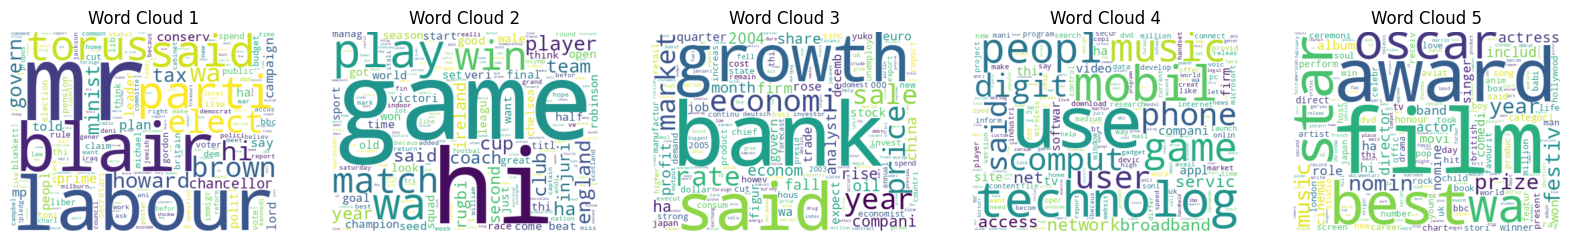

In [267]:
# Generate word cloud for test file
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for cloudI, topic in enumerate(H_test):
    top_terms_dict = {features[i]: topic[i] for i in range(len(topic))}

    # Generate the word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(top_terms_dict)

    # Display the word cloud in the subplot
    axes[cloudI].imshow(wordcloud, interpolation='bilinear')
    axes[cloudI].set_title(f"Word Cloud {cloudI + 1}")
    axes[cloudI].axis("off")

In [268]:
# apply previously trained in-sample prediction to test sample

# In sample prediction
highestWeight_test = np.argmax(W_test, axis=1)
predictedCategory = [finalPerm[i] for i in highestWeight_test]
bbc_test['predictedCategory'] = predictedCategory

In [269]:
# import test file solution

bbc_test_join = bbc_test.merge(bbc_test_solution, how="left", on="ArticleId")
bbc_test_join

,ArticleId,Text,Tokens,predictedCategory,Category
0,1018,qpr keeper day head for preston queen park ran...,"[qpr, keeper, day, heads, for, preston, queens...",sport,sport
1,1319,softwar watch while you work softwar that can ...,"[software, watching, while, you, work, softwar...",entertainment,tech
2,1138,d arci injuri add to ireland woe gordon d arci...,"[d, arcy, injury, adds, to, ireland, woe, gord...",sport,business
3,459,india s relianc famili feud heat up the ongo p...,"[india, s, reliance, family, feud, heats, up, ...",business,entertainment
4,1020,boro suffer morrison injuri blow middlesbrough...,"[boro, suffer, morrison, injury, blow, middles...",sport,politics
...,...,...,...,...,...
730,1923,eu to probe alitalia state aid the european co...,"[eu, to, probe, alitalia, state, aid, the, eur...",business,sport
731,373,u2 to play at grammi award show irish rock ban...,"[u2, to, play, at, grammy, awards, show, irish...",tech,tech
732,1704,sport bet rule in spotlight a group of mp and ...,"[sport, betting, rules, in, spotlight, a, grou...",entertainment,business
733,206,alfa romeo to get gm engin fiat is to stop mak...,"[alfa, romeos, to, get, gm, engines, fiat, is,...",business,entertainment


Unfortunately Out of Sample Prediction Accuracy is only about 20% - which is not better than random guess in 5 categories. Improvement to this accuracy would likely require (1) more in-depth knowledge in NLP, (2) more training sets, (3) exploring new techniques, or a combination of above

In [270]:
accuracy = accuracy_score(bbc_test_join['Category'], bbc_test_join['predictedCategory'])
print(f"Accuracy: {accuracy:.2f}")

confusionMatrix = confusion_matrix(bbc_test_join['Category'], bbc_test_join['predictedCategory'], labels=bbc_test_join['Category'].unique())
print(confusionMatrix)

Accuracy: 0.20
[[36 16 42 28 25]
 [29 21 37 26 34]
 [39 21 36 28 23]
 [31 19 38 30 29]
 [39 26 30 29 23]]


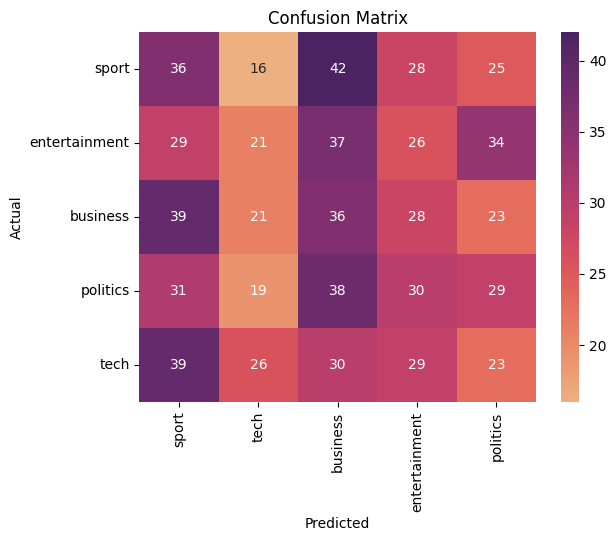

In [278]:
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='flare', xticklabels=bbc_test_join['Category'].unique(), yticklabels=bbc_test_join['predictedCategory'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Comparison with a supervised model - Logistic Regression

Logistic regression overall performed slightly better than matrix factorization classification. Logistic regression produced an in-sample cross-fold validation accuracy of about 97%. Out-sample accuracy is found to be at 22%, marginally better than before

In [304]:
X = bbc_train['Text']
X_test = bbc_test['Text']
y = bbc_train['Category']

X_tfidf = vectorizer.fit_transform(X)
X_test_tfidf = vectorizer.fit_transform(X_test)
y_tfidf = vectorizer.transform(y)

In [305]:
model = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(model, X_tfidf, y, cv=10, scoring='accuracy')
print(f"In-Sample accuracy: {cv_scores.mean():.2f}")

In-Sample accuracy: 0.97


In [310]:
model.fit(X_tfidf, y)
X_test_prediction = model.predict(X_test_tfidf)

accuracy = accuracy_score(bbc_test_join['Category'], X_test_prediction)
print(f"Test (out sample) accuracy: {accuracy}")

Test (out sample) accuracy: 0.21904761904761905


# Part 2: Limitation of NMF